In [1]:
!pip install fasttext --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
df = pd.read_csv('mlft_preprocessedv2.csv')
df.head()

,content,score,casefold,remove noise,slang,stopwords,stopwords2,stem,sentiment
0,sangat membantu terimakasih stockbit,5,sangat membantu terimakasih stockbit,sangat membantu terimakasih stockbit,sangat membantu terima kasih stockbit,membantu terima kasih stockbit,membantu terima kasih stockbit,bantu terima kasih stockbit,pos
1,"Aplikasi sudah bagis, fitur san tampilan enak,...",5,"aplikasi sudah bagis, fitur san tampilan enak,...",aplikasi sudah bagis fitur san tampilan enak m...,aplikasi sudah bagis fitur san tampilan enak m...,aplikasi bagis fitur san tampilan enak mudah p...,aplikasi bagis fitur san tampilan enak mudah p...,aplikasi bagis fitur san tampil enak mudah pah...,pos
2,Semoga aplikasi ini berguna bagi konsumen 😍😍😍,5,semoga aplikasi ini berguna bagi konsumen 😍😍😍,semoga aplikasi ini berguna bagi konsumen,semoga aplikasi ini berguna bagi konsumen,semoga aplikasi berguna konsumen,semoga aplikasi berguna konsumen,moga aplikasi guna konsumen,pos
3,Aplikasi yg bagus untuk belajar jad investor m...,5,aplikasi yg bagus untuk belajar jad investor m...,aplikasi yg bagus untuk belajar jad investor m...,aplikasi yang bagus untuk belajar jadi investo...,aplikasi bagus belajar investor trader,aplikasi bagus belajar investor trader,aplikasi bagus ajar investor trader,pos
4,Bagus untuk pemula yang mau terjuan ke dunia p...,5,bagus untuk pemula yang mau terjuan ke dunia p...,bagus untuk pemula yang mau terjuan ke dunia p...,bagus untuk pemula yang mau terjuan ke dunia p...,bagus pemula terjuan dunia persahaman crypto a...,bagus pemula terjuan dunia persahaman crypto a...,bagus mula juan dunia saham crypto admin stock...,pos


In [ ]:
X = df['stopwords'].astype(str)
y = df['sentiment'].astype(str)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
!gunzip -k cc.id.300.bin.gz

--2025-12-15 16:14:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.74.45, 13.227.74.9, 13.227.74.12, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.74.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘cc.id.300.bin.gz’

cc.id.300.bin.gz    100%[===================>]   4.20G  76.3MB/s    in 57s     

2025-12-15 16:15:45 (75.1 MB/s) - ‘cc.id.300.bin.gz’ saved [4507049071/4507049071]



In [5]:
import fasttext

ft_model = fasttext.load_model('/content/drive/MyDrive/kuliah/MLFT/cc.id.300.bin')

In [6]:
!pip install tensorflow

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

In [8]:
import numpy as np

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = ft_model.get_dimension()

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model.get_word_vector(word)

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (4181, 300)


In [9]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [20]:
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_sequence_length,
        trainable=False
    ),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     1,254,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,254,300 (4.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,254,300 (4.78 MB)

In [21]:
from sklearn.utils.class_weight import compute_class_weight

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

history = model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_test_pad, y_test_enc),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Class Weights: {0: np.float64(1.0001965408805031), 1: np.float64(0.999803536345776)}
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7224 - loss: 0.5636 - val_accuracy: 0.7675 - val_loss: 0.6303 - learning_rate: 5.0000e-04
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8393 - loss: 0.3747 - val_accuracy: 0.8209 - val_loss: 0.5552 - learning_rate: 5.0000e-04
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8367 - loss: 0.3735 - val_accuracy: 0.8342 - val_loss: 0.4977 - learning_rate: 5.0000e-04
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8594 - loss: 0.3455 - val_accuracy: 0.8193 - val_loss: 0.4378 - learning_rate: 5.0000e-04
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8595 - loss: 0.3337 - val_accuracy: 0.8413 - val_loss: 0.3938 - learning_rate: 5.0000e-04
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8724 - loss: 0.3123 - val_accuracy: 0.8484 - val_loss: 0.3653 - learning_ra

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


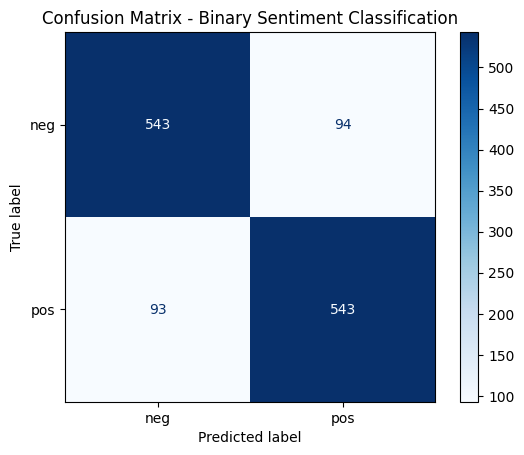


Classification Report:
              precision    recall  f1-score   support

         neg       0.85      0.85      0.85       637
         pos       0.85      0.85      0.85       636

    accuracy                           0.85      1273
   macro avg       0.85      0.85      0.85      1273
weighted avg       0.85      0.85      0.85      1273



In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Binary Sentiment Classification")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

### Save the Sentiment Classification Model

In [23]:
model.save('sentiment_model.h5')
print("Sentiment classification model saved as sentiment_model.h5")

Sentiment classification model saved as sentiment_model.h5


#Test Classification Model Topic

In [26]:
import pandas as pd
df = pd.read_csv('/content/mlft_preprocessed_topic.csv')
df.head()

,content,score,casefold,remove noise,slang,stopwords,stopwords2,stem,sentiment,topic
0,sangat membantu terimakasih stockbit,5,sangat membantu terimakasih stockbit,sangat membantu terimakasih stockbit,sangat membantu terima kasih stockbit,membantu terima kasih stockbit,membantu terima kasih stockbit,bantu terima kasih stockbit,pos,2
1,"Aplikasi sudah bagis, fitur san tampilan enak,...",5,"aplikasi sudah bagis, fitur san tampilan enak,...",aplikasi sudah bagis fitur san tampilan enak m...,aplikasi sudah bagis fitur san tampilan enak m...,aplikasi bagis fitur san tampilan enak mudah p...,aplikasi bagis fitur san tampilan enak mudah p...,aplikasi bagis fitur san tampil enak mudah pah...,pos,0
2,Semoga aplikasi ini berguna bagi konsumen 😍😍😍,5,semoga aplikasi ini berguna bagi konsumen 😍😍😍,semoga aplikasi ini berguna bagi konsumen,semoga aplikasi ini berguna bagi konsumen,semoga aplikasi berguna konsumen,semoga aplikasi berguna konsumen,moga aplikasi guna konsumen,pos,0
3,Aplikasi yg bagus untuk belajar jad investor m...,5,aplikasi yg bagus untuk belajar jad investor m...,aplikasi yg bagus untuk belajar jad investor m...,aplikasi yang bagus untuk belajar jadi investo...,aplikasi bagus belajar investor trader,aplikasi bagus belajar investor trader,aplikasi bagus ajar investor trader,pos,3
4,Bagus untuk pemula yang mau terjuan ke dunia p...,5,bagus untuk pemula yang mau terjuan ke dunia p...,bagus untuk pemula yang mau terjuan ke dunia p...,bagus untuk pemula yang mau terjuan ke dunia p...,bagus pemula terjuan dunia persahaman crypto a...,bagus pemula terjuan dunia persahaman crypto a...,bagus mula juan dunia saham crypto admin stock...,pos,2


In [27]:
df.value_counts('topic')

,count
topic,
0,1417
1,1092
3,897
2,867
4,773
7,503
6,499
5,312
-1,2


In [28]:
df = df[df['topic'] != -1]
df.value_counts('topic')

,count
topic,
0,1417
1,1092
3,897
2,867
4,773
7,503
6,499
5,312


In [29]:
X = df['stem'].astype(str)
y = df['topic'].astype(int)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

In [32]:
import numpy as np

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = ft_model.get_dimension()

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model.get_word_vector(word)

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (4174, 300)


In [33]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [34]:
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_sequence_length,
        trainable=False
    ),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(8, activation='softmax')
])

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # Changed loss function
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     1,252,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,252,200 (4.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,252,200 (4.78 MB)

In [35]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical # Ensure to_categorical is imported if not already

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# One-hot encode the labels to match the model's output shape for binary_crossentropy
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_enc, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_enc, num_classes=num_classes)

history = model.fit(
    X_train_pad, y_train_one_hot, # Use one-hot encoded labels
    validation_data=(X_test_pad, y_test_one_hot), # Use one-hot encoded labels
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Class Weights: {0: np.float64(0.5613415710503089), 1: np.float64(0.7210884353741497), 2: np.float64(0.9111747851002865), 3: np.float64(0.8784530386740331), 4: np.float64(1.0324675324675325), 5: np.float64(2.4747081712062258), 6: np.float64(1.6307692307692307), 7: np.float64(1.6391752577319587)}
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.3044 - loss: 2.0198 - val_accuracy: 0.3019 - val_loss: 1.9492 - learning_rate: 0.0010
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5626 - loss: 1.2099 - val_accuracy: 0.3648 - val_loss: 1.7551 - learning_rate: 0.0010
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6249 - loss: 1.0393 - val_accuracy: 0.4568 - val_loss: 1.5568 - learning_rate: 0.0010
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6844 - loss: 0.8671 - val_accuracy: 0.4976 - val_loss: 1.3789 - learning_rate: 0.0010
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7063 - loss: 0.8012 - val_accuracy

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


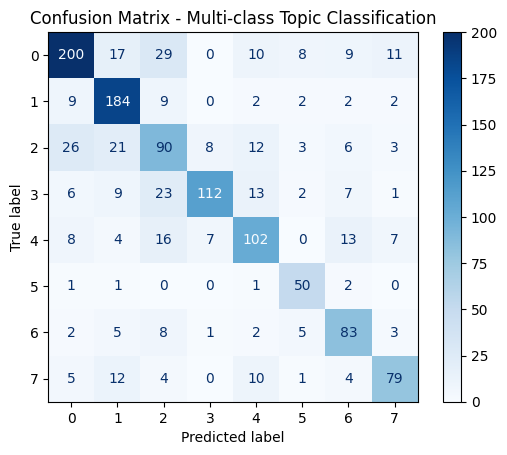


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       284
           1       0.73      0.88      0.79       210
           2       0.50      0.53      0.52       169
           3       0.88      0.65      0.74       173
           4       0.67      0.65      0.66       157
           5       0.70      0.91      0.79        55
           6       0.66      0.76      0.71       109
           7       0.75      0.69      0.71       115

    accuracy                           0.71      1272
   macro avg       0.71      0.72      0.71      1272
weighted avg       0.72      0.71      0.71      1272



In [36]:
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1) # Changed to argmax for multi-class

cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Multi-class Topic Classification") # Updated title
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_.astype(str))) # Convert class names to string

### Save the Topic Classification Model

In [37]:
# The 'model' variable was overwritten by the topic classification model training.
# Assuming the last trained model in the notebook state (cell `P_m0worq3mo6`) is the topic classification model.
model.save('topic_model.h5')
print("Topic classification model saved as topic_model.h5")

Topic classification model saved as topic_model.h5
